In [1]:
#FER2013のモデルを転移学習に活用してみる

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import glob
import os
import random
import urllib
from tensorflow.keras import layers
import tensorflow_io as tfio


#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
#import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

import pydot
import pydotplus
import graphviz
from keras.utils.vis_utils import plot_model

In [2]:

#【フォルダ内のjpgファイルを一覧表示】
data_folder = pathlib.Path("C:/Users/5010173/AI/datasets/face_AIST")

all_image_paths = list(data_folder.glob('**/*.jpg'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
#print(image_count)

#フォルダ内のjpgファイルのテンソルへのデコードの関数化
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image[150:650,50:550], [48, 48])
  image = tfio.experimental.color.rgb_to_grayscale(image) #グレースケール変換
  image /= 255.0  # normalize to [0,1] range
  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)



#【ラベルの読み込み】　ラベルは一つずつなのか？同時に二つは無理なのか？　→　まずは一つずつ処理する
label_path = pathlib.Path("C:/Users/5010173/AI/datasets/face_AIST/FacialExpressionDB_score.csv")
df1 = pd.read_csv(label_path, encoding= "utf-8")

#複数のインデックスを指定
df2 = df1.set_index(['axis', 'Model', 'FaceAngle'])
#display(df2.head(7)) #先頭7行を表示
#print(df2.columns)

#print(all_image_paths)
#print(type(all_image_paths))
#all_image_paths.sort() #パスをソート
#print(all_image_paths[:10])



#【画像のパスの中から、Modelと感情とFaceAngleを抽出する】
#print(type(all_image_paths[0]))
#print(len(all_image_paths))

all_image_paths_Model = []
all_image_paths_info = []
path_base = 'face_AIST'
path_base2 = 'jpg'

for i in range(len(all_image_paths)):
    idx = all_image_paths[i].find(path_base)
    idx2 = all_image_paths[i].find(path_base2)
    all_image_paths_Model.append(all_image_paths[i][idx+10:idx+13])
    all_image_paths_info.append(all_image_paths[i][idx+18:idx2-1])
del i,idx,idx2
#print(all_image_paths_Model[:10])
#print(all_image_paths_info[:10])

all_image_paths_FaceAngle = []
all_image_paths_Emotion = []
path_base = '_'

for i in range(len(all_image_paths)):
    idx = all_image_paths_info[i].find(path_base)
    all_image_paths_Emotion.append(all_image_paths_info[i][:idx])
    all_image_paths_FaceAngle.append(all_image_paths_info[i][idx+1:])
del i,idx

#リスト内の0をfrontに置換
#all_image_paths_FaceAngle = [s.replace('0', 'front') for s in all_image_paths_FaceAngle]
all_image_paths_FaceAngle = ['front' if s=='0' else s for s in all_image_paths_FaceAngle]

#print(all_image_paths_Model[:10])
#print(all_image_paths_Emotion[:10])
#print(all_image_paths_FaceAngle[:10])



#感情のタグをリストとして抽出(不要コード)
Emotag = df2.columns
#print(Emotag)
#【データフレームdf3の項目名を変更】
df3 = df2.rename(index = str.lower)
df3.rename(columns = {'Anger_cl':'angcl', 'Anger_op':'angop', 'Disgust_cl':'discl', \
    'Disgust_op':'disop', 'Excitement':'exc', 'Fear':'fea', 'Happiness':'hap', \
        'Neutral':'neu', 'Relaxation':'rel', 'Sadness':'sad', 'Sleepiness':'sle', \
            'Surprise':'sur'}, inplace = True) 
display(df3.head(7))



#複数インデックスのデータフレーム内の要素へのアクセスのテスト(不要コード)
#print(df2.loc[('Valence','f01', 'Front'),'Anger_cl'])
#【データフレームdf3から、各画像のラベルを抽出してリストに格納】
paths_Valence = []
paths_Arousal = []
for i in range(len(all_image_paths)):
    paths_Valence.append(df3.loc[('valence',all_image_paths_Model[i], all_image_paths_FaceAngle[i]),all_image_paths_Emotion[i]])
    paths_Arousal.append(df3.loc[('arousal',all_image_paths_Model[i], all_image_paths_FaceAngle[i]),all_image_paths_Emotion[i]])
del i
print(paths_Valence[:10])
print(paths_Arousal[:10])
#このように、教師データとラベルをそれぞれ順序一致させてリストに入れれば、データセットが出来る


#データセットはadarray型にする
#おそらくもっと良い読み込み方あるけど、いったんこのやり方で。
images = []
for i in range(len(all_image_paths)):
   images.append(load_and_preprocess_image(all_image_paths[i]))
Ids_raw = np.array(images)  #画像データセット
print(Ids_raw.shape)

LdsV_raw = np.array(paths_Valence)  #Valenceラベルデータセット
LdsA_raw = np.array(paths_Arousal)  #Arousalラベルデータセット


#訓練データとテストデータに分割（検証用データはモデル内で定義）
Ids_train, Ids_test = np.split(Ids_raw,[400],0)
LdsV_train, LdsV_test = np.split(LdsV_raw,[400],0)
LdsA_train, LdsA_test = np.split(LdsA_raw,[400],0)

angcl     angop     discl     disop       exc  \
axis    Model FaceAngle                                                     
valence f01   right90    3.025641  2.974359  2.743590  2.794872  6.615385   
              right45    2.487179  2.435897  2.743590  2.333333  7.974359   
              front      2.435897  2.487179  2.641026  2.230769  7.923077   
              left45     2.153846  2.666667  2.692308  2.179487  7.897436   
              left90     2.615385  2.307692  2.743590  2.333333  7.794872   
        f02   right90    3.205128  2.769231  2.410256  2.384615  6.948718   
              right45    3.205128  2.743590  2.666667  2.282051  7.692308   

                              fea       hap       neu       rel       sad  \
axis    Model FaceAngle                                                     
valence f01   right90    3.743590  6.589744  5.076923  6.564103  3.230769   
              right45    2.666667  7.743590  4.923077  7.179487  3.256410   
              front      2.615385  7.307692  4.846154  6.846154  2.846154   
              left45     2.589744  7.333333  4.743590  6.846154  2.743590   
              left90     2.641026  7.205128  4.717949  7.076923  3.025641   
        f02   right90    3.435897  7.615385  6.179487  7.076923  3.128205   
              right45    3.076923  7.692308  5.692308  7.179487  3.307692   

                              sle       sur  
axis    Model FaceAngle                      
valence f01   right90    4.692308  4.794872  
              right45    5.000000  5.589744  
              front      5.179487  5.641026  
              left45     5.025641  5.589744  
              left90     5.153846  4.820513  
        f02   right90    5.461538  4.743590  
              right45    5.512821  4.794872

[3.435897436, 4.923076923, 2.58974359, 2.58974359, 7.128205128, 2.41025641, 4.897435897, 7.41025641, 2.307692308, 3.435897436]
[5.473684211, 4.641025641, 5.076923077, 6.794871795, 4.435897436, 5.526315789, 4.769230769, 7.025641026, 7.051282051, 5.538461538]
(480, 48, 48, 1)


In [3]:
'''
#モデルの構築
def build_model():
  model = keras.Sequential([
    layers.Flatten(input_shape=(128, 128)),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()
'''

'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adam

model = Sequential()
#畳み込み層1
model.add(
  Conv2D(filters = 16,
               kernel_size = (3,3),
               padding = 'same',
               input_shape = (128, 128, 1),
               activation = 'relu'
               ))
#プーリング層
model.add(MaxPooling2D(pool_size = (4,4)))
#ドロップアウト
model.add(Dropout(0.5))
#畳み込み層2
model.add(
  Conv2D(filters = 32,
               kernel_size = (3,3),
               padding = 'same',
               input_shape = (32, 32, 1),
               activation = 'relu'
               ))
#プーリング層
model.add(MaxPooling2D(pool_size = (2,2)))
#ドロップアウト
model.add(Dropout(0.5))
#畳み込み層3
model.add(
  Conv2D(filters = 32,
               kernel_size = (3,3),
               padding = 'same',
               input_shape = (16, 16, 1),
               activation = 'relu'
               ))
#プーリング層
model.add(MaxPooling2D(pool_size = (2,2)))
#ドロップアウト
model.add(Dropout(0.5))
#1次元化
model.add(Flatten())  #(8,8,32)->(2042)にフラット化
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

#model.compile(
#  loss = 'sparse_categorical_crossentropy',
#         optimizer = SGD(lr=0.1),
#         metrics = ['accuracy'])

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model.summary()

plot_model(model, show_shapes=True, show_layer_names=True)
'''

"\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D\nfrom tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adam\n\nmodel = Sequential()\n#畳み込み層1\nmodel.add(\n  Conv2D(filters = 16,\n               kernel_size = (3,3),\n               padding = 'same',\n               input_shape = (128, 128, 1),\n               activation = 'relu'\n               ))\n#プーリング層\nmodel.add(MaxPooling2D(pool_size = (4,4)))\n#ドロップアウト\nmodel.add(Dropout(0.5))\n#畳み込み層2\nmodel.add(\n  Conv2D(filters = 32,\n               kernel_size = (3,3),\n               padding = 'same',\n               input_shape = (32, 32, 1),\n               activation = 'relu'\n               ))\n#プーリング層\nmodel.add(MaxPooling2D(pool_size = (2,2)))\n#ドロップアウト\nmodel.add(Dropout(0.5))\n#畳み込み層3\nmodel.add(\n  Conv2D(filters = 32,\n               kernel_size = (3,3),\n               padding = 'same',\n               input_shape = (16, 16, 1),\n        

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

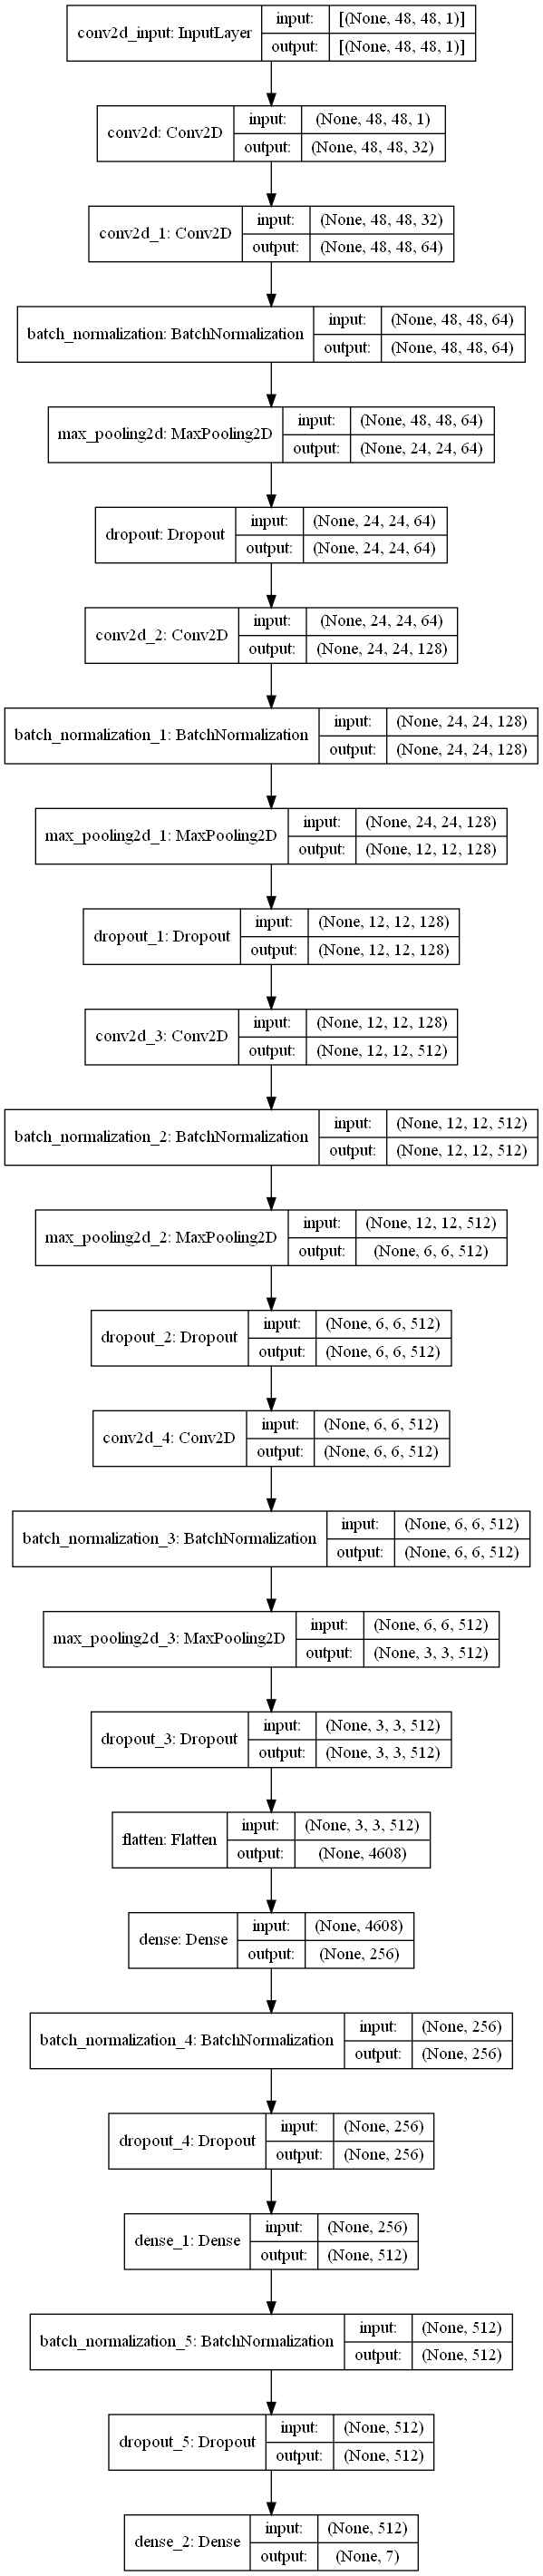

In [4]:
#モデルのロード
model = keras.models.load_model('C:/Users/5010173/venv01/main/kaggle/FER2013/model/model_optimal.h5')
model.summary()

plot_model(model, show_shapes=True, show_layer_names=True)

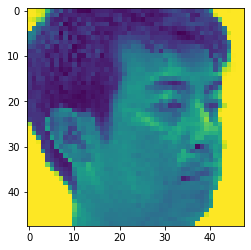

In [5]:
'''
#画像のリサイズサイズの見極め

#画像のリサイズ
image_check = image.load_img("C:/Users/5010173/AI/datasets/face_AIST/f01/f01_angcl_right45.jpg")
image_check= np.array(image_check)
plt.imshow(image_check)
print(image_check.shape)

(width, height) = (48, 48)
image_check_resize = cv2.resize(image_check[150:650,50:550], (width, height))
plt.imshow(image_check_resize)
print(image_check_resize.shape)
'''

plt.imshow(Ids_train[1,:])


In [6]:
#既存モデルの重みの固定
#for layer in model.layers[:]:
#    layer.trainable = False

#model.pop()  #最終レイヤーの削除
#model.add(BatchNormalization())
#model.add(Dropout(0.25))
#model.add(Dense(1, activation='softmax'))

model2 = tf.keras.Sequential([
    model,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1)
])

for layer in model2.layers:  #重みが固定されているかの確認
	print(layer, layer.trainable)

model2.summary()

plot_model(model2, show_shapes=True, show_layer_names=True)

optimizer = tf.keras.optimizers.RMSprop(0.001)
model2.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

<keras.engine.sequential.Sequential object at 0x0000025B32EAC0A0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000025AF018E580> True
<keras.layers.core.Dropout object at 0x0000025B32E94FA0> True
<keras.layers.core.Dense object at 0x0000025AF01C14F0> True
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 7)                 4496903   
_________________________________________________________________
batch_normalization (BatchNo (None, 7)                 28        
_________________________________________________________________
dropout (Dropout)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8         
Total params: 4,496,939
Trainable params: 4,492,957
Non-trainable params: 3,982
___________

In [7]:

#モデルの訓練
#エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
EPOCHS = 400

# patience は改善が見られるかを監視するエポック数を表すパラメーター
#これ入れるとうまく計算できなかったので、一旦このコールバックは付けない
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#Valenceの訓練
history_V = model2.fit(
  Ids_train, LdsV_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=1,
  callbacks=[PrintDot()])
  #callbacks=[early_stop, PrintDot()])

#Arousalの訓練
history_A = model2.fit(
  Ids_train, LdsA_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=1,
  callbacks=[PrintDot()])
  #callbacks=[early_stop, PrintDot()])


Epoch 1/400
10/10 [==============================] - 11s 63ms/step - loss: 25.1593 - mae: 4.4117 - mse: 24.2133 - val_loss: 35.6233 - val_mae: 5.5048 - val_mse: 34.3957

.Epoch 2/400
10/10 [==============================] - 0s 29ms/step - loss: 23.6354 - mae: 4.2736 - mse: 22.3761 - val_loss: 33.8549 - val_mae: 5.3490 - val_mse: 32.5344
.Epoch 3/400
10/10 [==============================] - 0s 29ms/step - loss: 24.5076 - mae: 4.3472 - mse: 23.1201 - val_loss: 35.5127 - val_mae: 5.4745 - val_mse: 34.0612
.Epoch 4/400
10/10 [==============================] - 0s 28ms/step - loss: 23.9296 - mae: 4.2791 - mse: 22.4502 - val_loss: 31.6584 - val_mae: 5.1101 - val_mse: 30.1353
.Epoch 5/400
10/10 [==============================] - 0s 29ms/step - loss: 22.9759 - mae: 4.2034 - mse: 21.3818 - val_loss: 28.3366 - val_mae: 4.7655 - val_mse: 26.6840
.Epoch 6/400
10/10 [==============================] - 0s 29ms/step - loss: 23.5929 - mae: 4.2053 - mse: 21.9230 - val_loss: 30.5697 - val_mae: 4.9979 - va

<class 'keras.callbacks.History'>
<class 'dict'>
dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


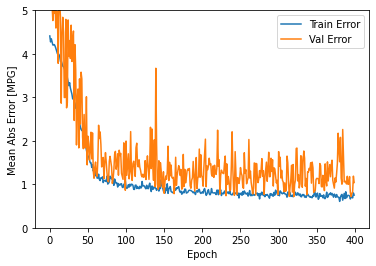

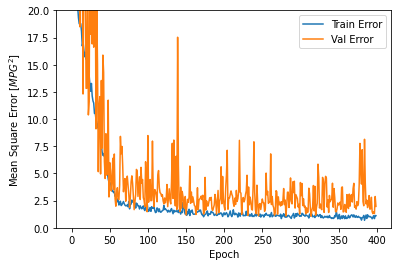

In [8]:
print(type(history_V))
print(type(history_V.history))
print(history_V.history.keys())


#モデルの訓練の様子の可視化_Valence
def plot_history(history_V):
  hist = pd.DataFrame(history_V.history)
  hist['epoch'] = history_V.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history_V)

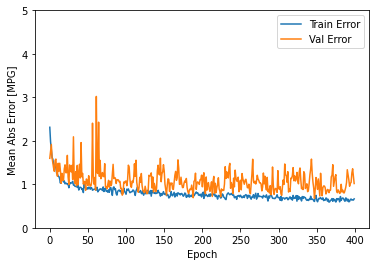

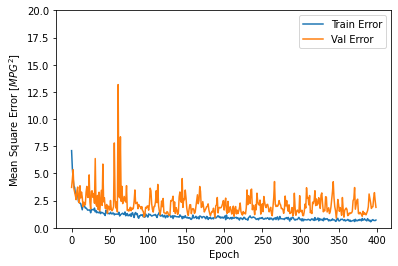

In [9]:
#モデルの訓練の様子の可視化_Arousal
def plot_history(history_A):
  hist = pd.DataFrame(history_A.history)
  hist['epoch'] = history_A.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history_A)

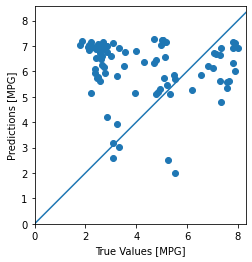

In [10]:
#テスト用ラベルで確認
#Valenceの推定

test_predictions_V = model2.predict(Ids_test).flatten()
plt.scatter(LdsV_test, test_predictions_V)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


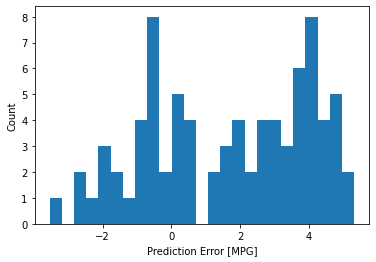

In [11]:
#Valenceの誤差分布
error_V = test_predictions_V - LdsV_test
plt.hist(error_V, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

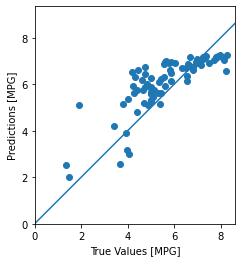

In [12]:
#テスト用ラベルで確認
#Arousalの推定
test_predictions_A = model2.predict(Ids_test).flatten()
plt.scatter(LdsA_test, test_predictions_A)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

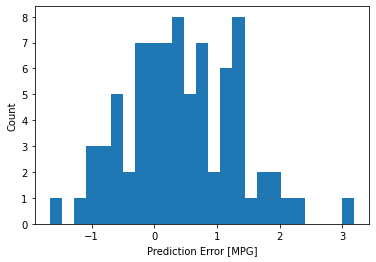

In [13]:
#Valenceの誤差分布
error_A = test_predictions_A - LdsA_test
plt.hist(error_A, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")